<a href="https://colab.research.google.com/github/shielamms/Tensorflow-Notebooks/blob/main/Eurovision_inspired_Lyrics_Generator_with_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data = None

with open('eurovision-lyrics-2022.json', 'r') as json_file:
  json_s = json_file.read()
  data = json.loads(json_s)

In [ ]:
data['0']['Lyrics translation']

"The birds of Holland are so musical\nThey already learn to twitter in their early youth\nThe blackbird, the thrush and the nightingale\nSo they can celebrate spring in Holland It's no wonder, because nowhere the puddles are so blue\nAs in Holland, sir\nAs in Holland, madam\nIt's no wonder, because nowhere the grass is so full of dew Are the girls so sweet, are the girls so faithfull\nAnd that's why all the birds here are\nSo musical, So musical, So musical Across the whole world I've heard birds sing\nTo the south, to the west, to the north\nIn many faraway countries I've heard birds sing\nThey sing little songs without words The French birds sing toodledoo\nJapanese birds sing toodledoo\nChinese birds sing toodledoo\nBut nowhere the birds sing so happily and cheerfully\nAs in Holland in spring in the meadow The birds of Holland are so musical\nThey already learn to twitter in their early youth\nThe blackbird, the thrush and the nightingale\nSo they can celebrate the spring in Holland

In [ ]:
all_song_lines = []

for i, lyrics in data.items():
  en_lyrics = lyrics['Lyrics translation']
  lines = [line.lower().strip() for line in en_lyrics.split('\n') if line]
  all_song_lines.extend(lines)

In [ ]:
len(all_song_lines)

26628

In [ ]:
all_song_lines[200]

'tomorrow it will be happiness in the sky, among the silver clouds'

In [ ]:
# def read_data_file(f):
#   song_lines = []

#   with open(f, 'r', encoding="ISO-8859-1") as lyrics_file:
#     reader = csv.reader(lyrics_file)
    
#     # skip header
#     next(reader)

#     for row in reader:
#       if not row[4].strip():
#         continue
#       # Convert all letters to lowercase
#       song_lines.append(row[4].strip().lower())

#   print(f'Found {len(song_lines)} lines')
#   return song_lines

# f = 'drive/MyDrive/taylor_swift_lyrics.csv'

# data = read_data_file(f)

## Text Preprocessing

### Tokenization and Sequencing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_song_lines)

In [ ]:
# Plus 1 for out-of-vocabulary words (OOV)
total_words = len(tokenizer.word_index) + 1
print(f'Total words: {total_words}')

Total words: 8274


In [ ]:
# Sample sequence
print(f'Original line: {all_song_lines[200]}')
print(f'Tokenized sequence: {tokenizer.texts_to_sequences([all_song_lines[200]])[0]}')

Original line: tomorrow it will be happiness in the sky, among the silver clouds
Tokenized sequence: [183, 14, 21, 19, 159, 9, 1, 130, 699, 1, 1518, 492]


In [ ]:
def generate_ngram_sequences(corpus, tokenizer):
  """
  Args:
    corpus : list of strings
    tokenizer : tensorflow tokenizer object
  """
  input_sequences = []

  for line in corpus:
    sequence = tokenizer.texts_to_sequences([line])[0]

    for i in range(1, len(sequence)):
      input_sequences.append(sequence[:i+1])

  return input_sequences

In [ ]:
# Sample
generate_ngram_sequences([all_song_lines[200]], tokenizer)

[[183, 14],
 [183, 14, 21],
 [183, 14, 21, 19],
 [183, 14, 21, 19, 159],
 [183, 14, 21, 19, 159, 9],
 [183, 14, 21, 19, 159, 9, 1],
 [183, 14, 21, 19, 159, 9, 1, 130],
 [183, 14, 21, 19, 159, 9, 1, 130, 699],
 [183, 14, 21, 19, 159, 9, 1, 130, 699, 1],
 [183, 14, 21, 19, 159, 9, 1, 130, 699, 1, 1518],
 [183, 14, 21, 19, 159, 9, 1, 130, 699, 1, 1518, 492]]

In [ ]:
input_sequences = generate_ngram_sequences(all_song_lines, tokenizer)

In [ ]:
print(f'Total number of input sequences: {len(input_sequences)}')

Total number of input sequences: 172249


In [ ]:
# get the longest sequence for use in padding later
max_sequence_len = max([len(s) for s in input_sequences])
print(f'Longest sequence: {max_sequence_len}')

Longest sequence: 202


In [ ]:
# Save the tokenizer
import json
from google.colab import files

tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

files.download('tokenizer.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Padding sequences

In [ ]:
def pad_seqs(input_sequences, maxlen):
  padded_sequences = pad_sequences(input_sequences, padding='pre', maxlen=maxlen)
  return padded_sequences

In [ ]:
# Sample
sample_line_sequences = generate_ngram_sequences([all_song_lines[200]], tokenizer)
pad_seqs(sample_line_sequences, max_sequence_len)

array([[   0,    0,    0, ...,    0,  183,   14],
       [   0,    0,    0, ...,  183,   14,   21],
       [   0,    0,    0, ...,   14,   21,   19],
       ...,
       [   0,    0,    0, ...,  130,  699,    1],
       [   0,    0,    0, ...,  699,    1, 1518],
       [   0,    0,    0, ...,    1, 1518,  492]], dtype=int32)

In [ ]:
padded_sequences = pad_seqs(input_sequences, max_sequence_len)

### Splitting to features and labels

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def split_features_labels(input_sequences, total_words):
  features = input_sequences[:, :-1]
  labels = input_sequences[:, -1]
  one_hot_labels = to_categorical(labels, num_classes=total_words)
  return features, one_hot_labels

In [ ]:
# Sample
sample_padded_sequences = pad_seqs(sample_line_sequences, max_sequence_len)
sample_features, sample_one_hot_labels = split_features_labels(sample_padded_sequences, total_words)

In [ ]:
print(f'Shape of sample features: {sample_features.shape}')
print(f'Shape of sample labels: {sample_one_hot_labels.shape}')

Shape of sample features: (11, 201)
Shape of sample labels: (11, 8274)


In [ ]:
features, labels = split_features_labels(padded_sequences, total_words)

print(f'Shape of features: {features.shape}')
print(f'Shape of labels: {labels.shape}')

Shape of features: (172249, 201)
Shape of labels: (172249, 8274)


## Model creation

In [ ]:
model = tf.keras.models.Sequential([
    # Input length is -1 because the last token in a sequence is the label
    tf.keras.layers.Embedding(total_words,
                              100,
                              input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])


In [ ]:
EPOCHS = 50

In [ ]:
history = model.fit(features, labels, epochs=EPOCHS, verbose=1)

Epoch 1/50
5383/5383 [==============================] - 137s 24ms/step - loss: 5.5621 - accuracy: 0.1320
Epoch 2/50
5383/5383 [==============================] - 102s 19ms/step - loss: 4.5113 - accuracy: 0.2200
Epoch 3/50
5383/5383 [==============================] - 103s 19ms/step - loss: 3.9481 - accuracy: 0.2783
Epoch 4/50
5383/5383 [==============================] - 103s 19ms/step - loss: 3.5650 - accuracy: 0.3211
Epoch 5/50
5383/5383 [==============================] - 102s 19ms/step - loss: 3.2893 - accuracy: 0.3578
Epoch 6/50
5383/5383 [==============================] - 102s 19ms/step - loss: 3.0822 - accuracy: 0.3854
Epoch 7/50
5383/5383 [==============================] - 103s 19ms/step - loss: 2.9243 - accuracy: 0.4089
Epoch 8/50
5383/5383 [==============================] - 103s 19ms/step - loss: 2.8038 - accuracy: 0.4281
Epoch 9/50
5383/5383 [==============================] - 103s 19ms/step - loss: 2.7159 - accuracy: 0.4428
Epoch 10/50
5383/5383 [==============================] 

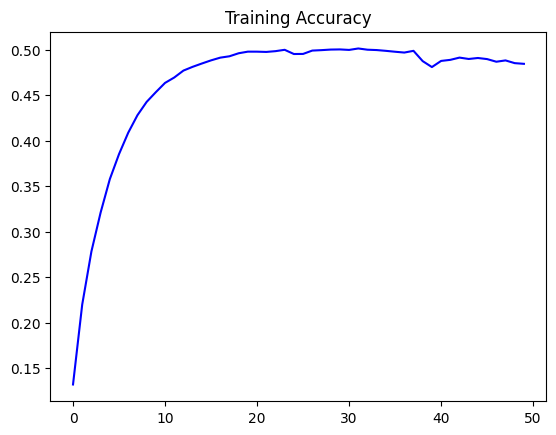

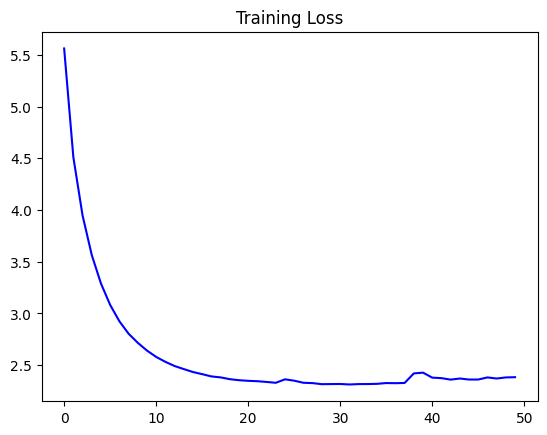

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.show()

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing

In [ ]:
seed_text = "Fly like a"
next_words = 10

for _ in range(next_words):
  sequence = tokenizer.texts_to_sequences([seed_text])[0]
  sequence = pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')
  prediction = model.predict(sequence, verbose=0)

  # Softmax returns a list of probabilities, get the token with the highest
  prediction = np.argmax(prediction, axis=-1).item()
  output = tokenizer.index_word[prediction]
  seed_text += " " + output

NameError: ignored

In [ ]:
seed_text

"I won't search for you if you want to find the mystery of"

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl
